In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/ColabFiles/Text_Recognition/autocorrect.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [ ]:
from scipy.ndimage import measurements,morphology
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.compat.v1 import keras
from autocorrect import Speller
import difflib
spell = Speller(lang='ru')

dictionary for this language not found, downloading...
__________________________________________________
couldn't download https://dl.dropboxusercontent.com/s/mpas7xqn8yl3wej/ru.tar.gz?dl=0, trying next url...
__________________________________________________
couldn't download https://dl.dropboxusercontent.com/s/6tzfxy34xx34mm7/ru.tar.gz?dl=0, trying next url...
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!


In [ ]:
def photoPreprocessing(img):
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  
  lower_range = np.array([0,0,0])
  upper_range = np.array([120,120,120])
  
  mask = cv2.inRange(hsv,lower_range,upper_range)

  mask = cv2.GaussianBlur(mask,(0,0),0.1)  

  contours,hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

  return contours

def get_LettersCoords(img):
  contours = photoPreprocessing(img)

  result = []
  letters = []
  arrW = []
  arrH = []

  if len(contours) !=0:
      for contour in contours:
          if cv2.contourArea((contour)) > 60:
              x,y,w,h = cv2.boundingRect(contour)
              
              arrW.append(w)
              arrH.append(w)

              result.append({'x': x,'y': y,'w': w,'h': h})

  arrW.sort()
  arrH.sort()

  meanW = arrW[len(arrW)//2]
  meanH = arrH[len(arrH)//2]

  for i in range(len(result)):
    if (abs(1 - (result[i]['w']+result[i]['h'])/(meanW+meanH)) <= 1.8) and ((1 - (result[i]['w']+result[i]['h'])/(meanW+meanH)) < 0.4):
      letters.append(result[i])
    
  return letters

def heapify(nums, heap_size, root_index, coord):  
    largest = root_index
    left_child = (2 * root_index) + 1
    right_child = (2 * root_index) + 2

    if left_child < heap_size and nums[left_child][coord] > nums[largest][coord]:
        largest = left_child


    if right_child < heap_size and nums[right_child][coord] > nums[largest][coord]:
        largest = right_child


    if largest != root_index:
        nums[root_index], nums[largest] = nums[largest], nums[root_index]

        heapify(nums, heap_size, largest, coord)

def attributeSort(nums,coord):  
    n = len(nums)

    for i in range(n, -1, -1):
        heapify(nums, n, i, coord)

    for i in range(n - 1, 0, -1):
        nums[i], nums[0] = nums[0], nums[i]
        heapify(nums, i, 0, coord)
    
    return nums
  
def get_spaces(coords, k, minMode = False):
  if len(coords) == 1:
    return []

  arrDistance = []
  for i in range(len(coords)-1):
    arrDistance.append(coords[i+1]['x'] - (coords[i]['x']+coords[i]['w']))

  if not minMode:
    arrDistance.sort()
    medianDistance = arrDistance[len(arrDistance) // 2]
  else:
    arrDistance.sort()
    medianDistance = arrDistance[len(arrDistance) // 2]
    medianDistance = (min(arrDistance) + medianDistance) / 2


  spaces = []
  for i in range(len(coords)-1):
    if (coords[i+1]['x'] - (coords[i]['x']+coords[i]['w']))/medianDistance > k:
      spaces.append(i)

  return spaces

def reshape_IMG(img,shape):
  reshapeImg = np.ones(shape)
  for m in range(img.shape[0]):
    for n in range(img.shape[1]):
      reshapeImg[m+int((shape[0] - img.shape[0]) > 0)*((shape[0] - img.shape[0]) // 2)][n+int((shape[1] - img.shape[1]) > 0)*((shape[1] - img.shape[1]) // 2)][0] = img[m][n][0]
  return reshapeImg

def addGap(img,gapSize):
  gappedImg = np.ones((img.shape[0]+2*gapSize, img.shape[1]+2*gapSize, 1))
  for m in range(img.shape[0]):
    for n in range(img.shape[1]):
      gappedImg[m+gapSize][n+gapSize][0] = img[m][n][0]
  return gappedImg

def normalizeImage(img):
  mean = np.mean(img)
  shape = img.shape
  img = np.reshape(img,(img.size))

  f = lambda num: ((int(num >= mean-0.2)-1)*2) + 1

  img = np.array(list(map(f,img)))

  img = img.reshape(shape)

  return img


def letterPreprocesing(img,coord,gapSize,size):
  let = np.array(img[coord['y']:coord['y']+coord['h'],coord['x']:coord['x']+coord['w']])
  let = (let-127.5)/127.5
  let = normalizeImage(let)
  let = addGap(let,gapSize)
  let = reshape_IMG(let,(max(let.shape[0],let.shape[1]),max(let.shape[0],let.shape[1]),1))
  let = cv2.resize(let,size)
  let = np.expand_dims(let,-1)

  return let

def predictRow(img,coords,size,gapSize):
  result = []
  rowResult = []

  for coord in coords:
    letter = letterPreprocesing(img,coord,gapSize,size)
    cv2_imshow(letter*255)
    row = model.predict(np.array([letter]))
    pos = np.argmax(row)

    rowResult.append(row)
    result.append(dic[str(pos)])

  return result, rowResult

def makeTokens(letters,row,spaces):
  word = ''
  wordArr = []
  rowArr = []

  result = []

  for i in range(len(letters)):
    if i not in spaces:
      word += letters[i]
      wordArr.append(letters[i])
      rowArr.append(row[i])
    else:
      word += letters[i]
      wordArr.append(letters[i])
      rowArr.append(row[i])
      result.append({'word': word, 'letters': wordArr,'probs': rowArr})
      word = ''
      wordArr = []
      rowArr = []
  result.append({'word': word, 'letters': wordArr,'probs': rowArr})

  return result


def get_goodCandidates(word):
  candidates = attributeSort(spell.autocorrect_word(word),0)
  candidates.reverse()

  goodCandidates = []
  for i in candidates:
    if (len(i[1]) == len(word)) and (i[1].lower() not in goodCandidates):
      goodCandidates.append(i[1].lower())
  
  return goodCandidates

def similarity(s1, s2): #Нахождение коэффициента схожести между двумя строками
  normalized1 = s1.lower()
  normalized2 = s2.lower()
  matcher = difflib.SequenceMatcher(None, normalized1, normalized2)
  return matcher.ratio()

def get_bestCandidate(token):
  candidates = get_goodCandidates(token['word'])

  first = token['word'][0]


  if len(candidates) == 1:
    if candidates[0][0] == first.lower():
      return first + candidates[0][1:]
    else:
      return candidates[0]
  else:
    maxSim = 0

    for i in candidates:
      if similarity(i,token['word']) > maxSim:
        maxSim = similarity(i,token['word'])
    
    preBest = []

    for i in candidates:
      if len(preBest) == 2:
        break
      if similarity(i,token['word']) == maxSim:
        preBest.append(i)
  
    maxProb = 0
    maxWord = token['word']


    for i in preBest:
      for s in range(len(i)):
        if (i[s] != token['word'].lower()[s]) and (token['probs'][s][0][int(revDic[i[s]])] > maxProb):
          maxProb = token['probs'][s][0][int(revDic[i[s]])]
          maxWord = i

    if maxWord[0] == first.lower():
      return first + maxWord[1:]
    else:
      return maxWord

def image2text(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

  coords = attributeSort(get_LettersCoords(img), 'x')
  spaces = get_spaces(coords, 1.5, True)
  print(spaces)
  letters, row = predictRow(img,coords,(64,64),30)

  print(letters)

  tokens = makeTokens(letters, row, spaces)

  text = ''

  for token in tokens:
    text += get_bestCandidate(token) + ' '

  return text[:len(text)-1]


In [ ]:
y = np.load('/content/drive/MyDrive/ColabFiles/Text_Recognition/save64_Y_D.npy')
letDict = pd.Series(y).unique()
catDict = pd.Series(y).astype('category').cat.codes.unique()
dic = {}
revDic = {}
for i in range(len(catDict)):
  dic[str(catDict[i])] = letDict[i] 
  revDic[letDict[i]] = str(catDict[i])
print(dic)
print(revDic)

{'0': 'а', '1': 'б', '2': 'в', '3': 'г', '4': 'д', '5': 'е', '6': 'ж', '7': 'з', '8': 'и', '9': 'й', '10': 'к', '11': 'л', '12': 'м', '13': 'н', '14': 'о', '15': 'п', '16': 'р', '17': 'с', '18': 'т', '19': 'у', '20': 'ф', '21': 'х', '22': 'ц', '23': 'ч', '24': 'ш', '25': 'щ', '26': 'ъ', '27': 'ы', '28': 'ь', '29': 'э', '30': 'ю', '31': 'я'}
{'а': '0', 'б': '1', 'в': '2', 'г': '3', 'д': '4', 'е': '5', 'ж': '6', 'з': '7', 'и': '8', 'й': '9', 'к': '10', 'л': '11', 'м': '12', 'н': '13', 'о': '14', 'п': '15', 'р': '16', 'с': '17', 'т': '18', 'у': '19', 'ф': '20', 'х': '21', 'ц': '22', 'ч': '23', 'ш': '24', 'щ': '25', 'ъ': '26', 'ы': '27', 'ь': '28', 'э': '29', 'ю': '30', 'я': '31'}


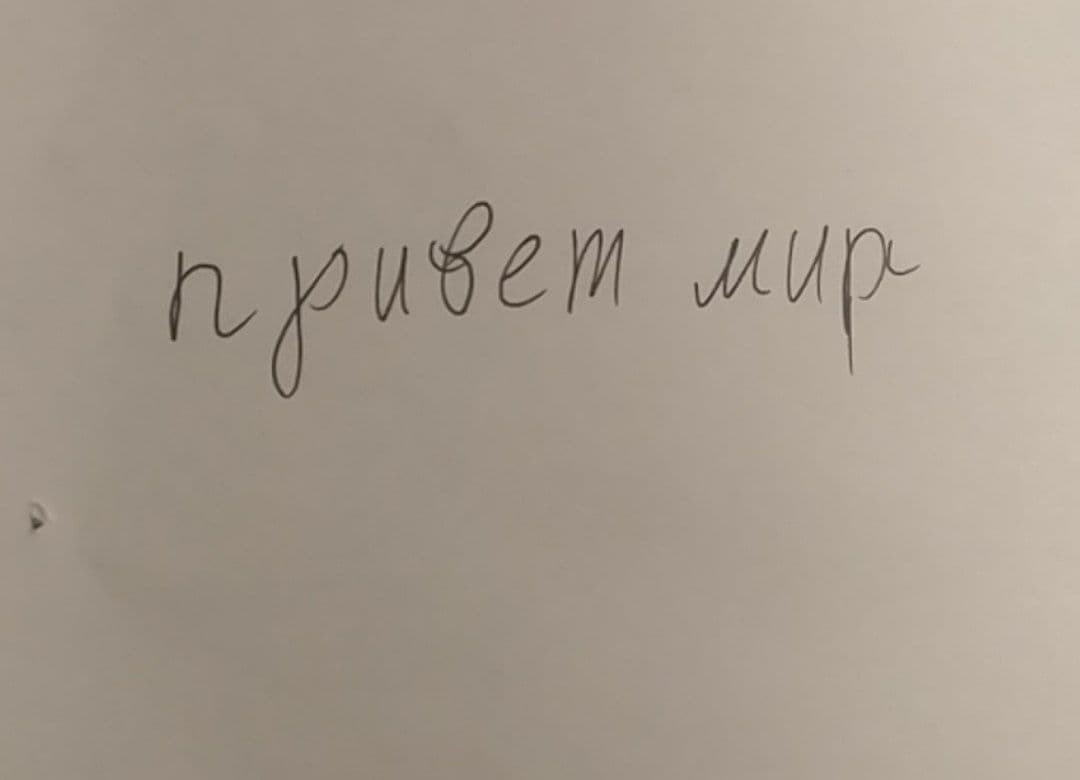

[1, 2, 4, 5]


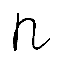

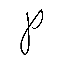

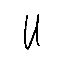

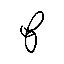

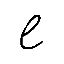

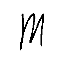

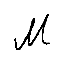

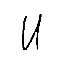

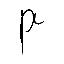

['п', 'р', 'и', 'в', 'е', 'т', 'м', 'и', 'р']


'пр и ве т мир'

In [ ]:
img = cv2.imread("/content/drive/MyDrive/ColabFiles/Text_Recognition/HelloWorld.jpg")
model = keras.models.load_model('/content/drive/MyDrive/ColabFiles/Text_Recognition/signRecog_101900_model_D.h5')
cv2_imshow(img)
image2text(img)

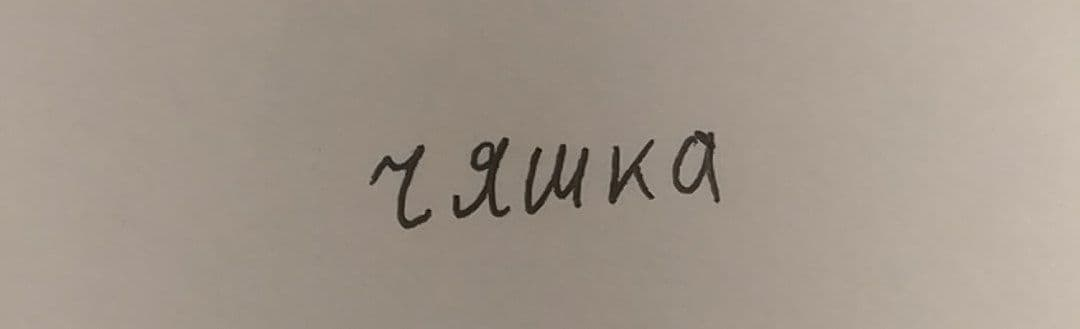

[]


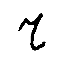

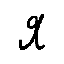

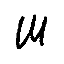

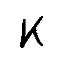

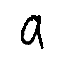

['ч', 'я', 'ш', 'к', 'а']


'чашка'

In [ ]:
img = cv2.imread("/content/Im4.jpg")
model = keras.models.load_model('/content/drive/MyDrive/ColabFiles/Text_Recognition/signRecog_101900_model_D.h5')
cv2_imshow(img)
image2text(img)